In [ ]:
# yolov5 segmentation model on official TACO

# 1. Preparation
 - import dependencies and download data

In [ ]:
mount_drive = True
reduced = True
bbox = False #bbox=True for bounding box detection, bbox=False for segmentation (mask) detection

In [ ]:
!nvidia-smi

Fri Feb 17 15:52:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
%rm -rf /content/*
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
!pip install -r requirements.txt wandb
!pip install --upgrade albumentations
%cd ..


In [ ]:
%%capture
!wget https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py
from iterative_stratification import *
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab
from collections import Counter


import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

import shutil
import os
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
if not mount_drive:
  !gdown 1X3O2v3GIPveq3ylWF6o1qHI5uzbN1vWA # download organized TACO images (TACO itself, 1500 images, without unofficial images)

if mount_drive:
  from google.colab import drive
  drive.mount('/gdrive')
  if not os.path.isfile('/content/rotated2.zip'):
    %cp /gdrive/MyDrive/rotated2_og.zip /content/rotated2.zip
    

Mounted at /gdrive


In [ ]:
%rm -rf /content/TACO/
!unzip -qq ./rotated2.zip 
%mv ./content/yoloTACO ./TACO
# TACO comes with labels, since we'll filter and reorganize these labels, we delete them to avoid duplication
%rm -rf ./TACO/labels

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json
#!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations_unofficial.json

# 2. Data pipeline

## get labels

In [ ]:
base_anno = './annotations.json'
unof_anno =  './annot?**ations_unofficial.json'

base_coco_anno = COCO(annotation_file=base_anno)
unof_coco_anno = COCO(annotation_file=unof_anno)

with open(base_anno, 'r') as f:
    base_anno = json.loads(f.read())

with open(unof_anno, 'r') as f:
    unof_anno = json.loads(f.read())   

# get the "id to superid" relationship
supercat_cat_id = [[i['supercategory'],i['name'],i['id']] for i in base_anno['categories']]
id_supercat = {i[2]:i[0] for i in supercat_cat_id}
super_id = {j:i for i,j in enumerate(list(dict.fromkeys([(j) for i,j in enumerate([i['supercategory'] for i in base_anno['categories']])])))}
id_superid = {i:super_id[id_supercat[i]] for i in range(60)}

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


## Reduce label classes

In [ ]:
!wget https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv

mkey = pd.read_csv('./material_key.csv')
mkey_dict = {i:j for i,j in zip(mkey.cat_id, mkey.m_id)}
mkey[:6]

,cat_id,category,m_id,material,illustration,illustration_
0,0,Aluminium foil,0,metal,metal,0.0
1,1,Battery,0,metal,plastic,1.0
2,2,Aluminium blister pack,0,metal,glass,2.0
3,3,Carded blister pack,1,plastic,paper,3.0
4,4,Other plastic bottle,1,plastic,other,4.0
5,5,Clear plastic bottle,1,plastic,NaN,NaN


## filter and reorder labels

In [ ]:
# %cd ..

In [ ]:
bbox_thold =  50*50 # threshold of bbox under which bbox will be discarded being too small
                  # threshold value = width*height, e.g. 40*40 = 1600 pixels


dst = "./TACO"

%rm -rf ./TACO/labels #reset labels
!mkdir ./TACO/labels

base_imgs = base_anno['images']


counter = 0
skip_counter = 0
obj_counter=0
for img in tqdm(base_imgs):
  height = img['height']
  width = img['width']

  # reorganize images
  img_id = img['id']

  annotation_ids = base_coco_anno.getAnnIds(img_id)

  if len(annotation_ids) == 0:
    continue

  with open(dst+'/labels/'+str(img_id)+'.txt', mode='w') as fp:
    annotations = base_coco_anno.loadAnns(annotation_ids)
    lines = ''
    for annotation in annotations:
      obj_counter+=1
      class_ = copy.copy(annotation['category_id'])
      class_ = mkey_dict[class_]
      box = copy.copy(annotation['bbox'])

      # some annotations have basically no width / height (extremely small), skip them
      if box[2] * box[3] < bbox_thold:
        skip_counter+=1 # count number of skippped bbox for being too small

        # uncomment below line to see which images have bbox skipped
        #print('bbox too small, skipped. skipped bbox is in image ID:'+ str(img_id))
        continue
      # top_x,top_y,width,height ----> cen_x,cen_y,width,height
      # standardize to 0-1
      box[0] = round((box[0] + box[2] / 2) / width, 6)
      box[1] = round((box[1] + box[3] / 2) / height, 6)
      box[2] = round(box[2] / width, 6)
      box[3] = round(box[3] / height, 6)
      # line: super_id x_center y_center width height
      lines += str(class_)
      for i in box:
        lines += ' ' + str(i)
      lines = lines+ '\n'
    fp.writelines(lines)

  counter+=1


print('\n\nNumber of skipped bbox, number of bbox in all:')
skip_counter,obj_counter

100%|██████████| 1500/1500 [00:00<00:00, 10374.05it/s]



Number of skipped bbox, number of bbox in all:


(876, 4784)

## train test split

In [ ]:
nr_imgs=None
for root, dirnames, filenames in os.walk('./TACO/labels/'):
  nr_imgs = len(filenames)
  break
print('Number of all images:\n'+str(nr_imgs))

nr_class = len(set(mkey_dict.values()))


Number of all images:
1500


In [ ]:
xy = {}
for i in tqdm(range(nr_imgs)):
  try: 
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    y=i
    xy[y]=x

  except: 
    print('\nimage id number '+str(i)+' skipped due to no label found')
    pass
X = pd.DataFrame.from_dict(xy, orient='index')

y = xy.keys()
one_hot_y = pd.get_dummies(y)

## train test split
'''
train: images/train
val: images/val
test: images/test
'''

np.random.seed(1) # sk-multilearn is based on sk, sk uses np random state. 
                  # so, setting np random seed will clamp the results of iterative_train_test_split

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, one_hot_y.values, test_size = 0.5)
X_train1, y_train1, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.5)
X_val, y_val,X_test,y_test = iterative_train_test_split(X_val, y_val, test_size = 0.5)

# ISSUE: in this environment, any test_size!= 0.5 results in nothing in testing set. 
# therefore train/val/test split is roughly .75, .125, .125

y_train = np.vstack((y_train,y_train1))
train_ids,val_ids,test_ids = pd.DataFrame(y_train,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_val,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_test,columns = y).idxmax(axis=1).tolist()


100%|██████████| 1500/1500 [00:01<00:00, 768.70it/s]


In [ ]:
# check no intersection
print(set(train_ids).intersection(set(val_ids)), set(train_ids).intersection(set(test_ids)), set(val_ids).intersection(set(test_ids)))

# check total number of img_ids
print(len(set(train_ids).union(set(val_ids)).union(set(test_ids))))

set() set() set()
1500


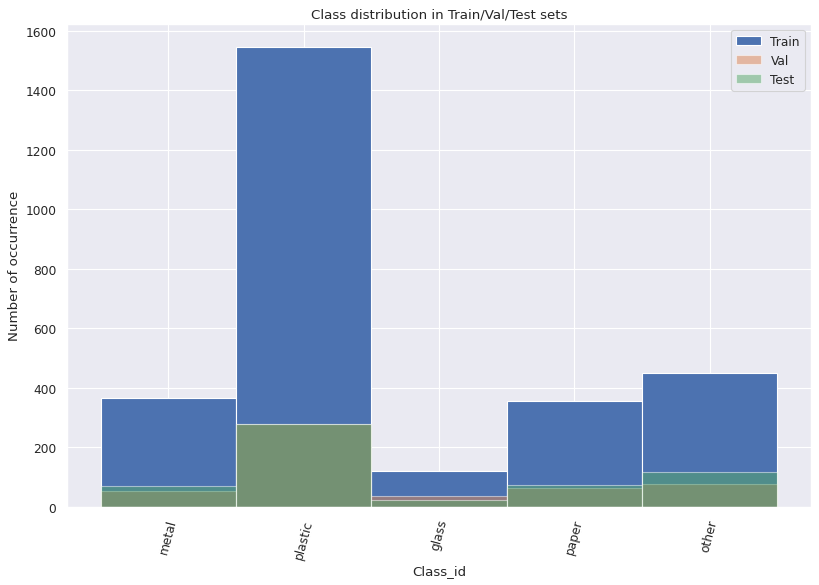

In [ ]:
# Visual check of train-test split

def list_add(list1, list2): 
  return [sum(x) for x in zip(list1, list2)]

def vis(img_id_list):
  vis=[0]*nr_class
  for i in img_id_list:
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x_ = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    vis=list_add(vis,x_)
  return vis

from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.bar([*range(nr_class)],vis(train_ids), width = 1, label = 'Train')
plt.bar([*range(nr_class)],vis(val_ids), width = 1, label = 'Val',alpha = 0.5)
plt.bar([*range(nr_class)],vis(test_ids), width = 1, label = 'Test',alpha = 0.5)

plt.xticks([0,1,2,3,4],['metal','plastic','glass','paper','other'],rotation = 75)
plt.xlabel("Class_id")
plt.ylabel("Number of occurrence")
plt.title("Class distribution in Train/Val/Test sets")
plt.legend()
plt.show()

In [ ]:
#%%capture

def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './TACO/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './TACO/labels', str(id)+'.txt' )
    #print(img_name)
    if os.path.isfile(img_name):
        shutil.copy( img_name, './TACO/images/'+desti)
        shutil.copy( lbl_name, './TACO/labels/'+desti)
    else :
        print('file does not exist', img_name)

!mkdir TACO/images/{train,val,test}
!mkdir TACO/labels/{train,val,test}

move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')


# 3. Hyper-parameter setting

In [ ]:
%cd ./yolov5
!ls

/content/yolov5
benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


In [ ]:
#@title data yml

with open('/content/yolov5/data/TACO.yaml', mode='w') as fp:
  lines = '''path: ../TACO  # dataset root dir
train: images/train  # train images 
val: images/val  # val images 
test: images/test # test images (optional)

# Classes
names:
  0: metal
  1: plastic
  2: glass
  3: paper
  4: other
'''
  fp.writelines(lines)

In [ ]:
#@title hyperparameter 1

with open('/content/yolov5/utils/metrics.py', mode='w') as fp:
  lines = """
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

import math
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from utils import TryExcept, threaded


def fitness(x):
    # Model fitness as a weighted combination of metrics
    w = [0.0, 0.7, 0.3, 0.0]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)


def smooth(y, f=0.05):
    # Box filter of fraction f
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode='valid')  # y-smoothed


def ap_per_class(tp, conf, pred_cls, target_cls, plot=False, save_dir='.', names=(), eps=1e-16, prefix=""):

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    px, py = np.linspace(0, 1, 1000), []  # for plotting
    ap, p, r = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci]  # number of labels
        n_p = i.sum()  # number of predictions
        if n_p == 0 or n_l == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (n_l + eps)  # recall curve
        r[ci] = np.interp(-px, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p[ci] = np.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if plot and j == 0:
                py.append(np.interp(px, mrec, mpre))  # precision at mAP@0.5

    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + eps)
    names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
    names = dict(enumerate(names))  # to dict
    if plot:
        plot_pr_curve(px, py, ap, Path(save_dir) / f'{prefix}PR_curve.png', names)
        plot_mc_curve(px, f1, Path(save_dir) / f'{prefix}F1_curve.png', names, ylabel='F1')
        plot_mc_curve(px, p, Path(save_dir) / f'{prefix}P_curve.png', names, ylabel='Precision')
        plot_mc_curve(px, r, Path(save_dir) / f'{prefix}R_curve.png', names, ylabel='Recall')

    i = smooth(f1.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    return tp, fp, p, r, f1, ap, unique_classes.astype(int)


def compute_ap(recall, precision):


    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec


class ConfusionMatrix:
    # Updated version of https://github.com/kaanakan/object_detection_confusion_matrix
    def __init__(self, nc, conf=0.25, iou_thres=0.45):
        self.matrix = np.zeros((nc + 1, nc + 1))
        self.nc = nc  # number of classes
        self.conf = conf
        self.iou_thres = iou_thres

    def process_batch(self, detections, labels):

        if detections is None:
            gt_classes = labels.int()
            for gc in gt_classes:
                self.matrix[self.nc, gc] += 1  # background FN
            return

        detections = detections[detections[:, 4] > self.conf]
        gt_classes = labels[:, 0].int()
        detection_classes = detections[:, 5].int()
        iou = box_iou(labels[:, 1:], detections[:, :4])

        x = torch.where(iou > self.iou_thres)
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        else:
            matches = np.zeros((0, 3))

        n = matches.shape[0] > 0
        m0, m1, _ = matches.transpose().astype(int)
        for i, gc in enumerate(gt_classes):
            j = m0 == i
            if n and sum(j) == 1:
                self.matrix[detection_classes[m1[j]], gc] += 1  # correct
            else:
                self.matrix[self.nc, gc] += 1  # true background

        if n:
            for i, dc in enumerate(detection_classes):
                if not any(m1 == i):
                    self.matrix[dc, self.nc] += 1  # predicted background

    def matrix(self):
        return self.matrix

    def tp_fp(self):
        tp = self.matrix.diagonal()  # true positives
        fp = self.matrix.sum(1) - tp  # false positives
        # fn = self.matrix.sum(0) - tp  # false negatives (missed detections)
        return tp[:-1], fp[:-1]  # remove background class

    @TryExcept('WARNING ⚠️ ConfusionMatrix plot failure')
    def plot(self, normalize=True, save_dir='', names=()):
        import seaborn as sn

        array = self.matrix / ((self.matrix.sum(0).reshape(1, -1) + 1E-9) if normalize else 1)  # normalize columns
        array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

        fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
        nc, nn = self.nc, len(names)  # number of classes, names
        sn.set(font_scale=1.0 if nc < 50 else 0.8)  # for label size
        labels = (0 < nn < 99) and (nn == nc)  # apply names to ticklabels
        ticklabels = (names + ['background']) if labels else "auto"
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
            sn.heatmap(array,
                       ax=ax,
                       annot=nc < 30,
                       annot_kws={
                           "size": 8},
                       cmap='Blues',
                       fmt='.2f',
                       square=True,
                       vmin=0.0,
                       xticklabels=ticklabels,
                       yticklabels=ticklabels).set_facecolor((1, 1, 1))
        ax.set_ylabel('True')
        ax.set_ylabel('Predicted')
        ax.set_title('Confusion Matrix')
        fig.savefig(Path(save_dir) / 'confusion_matrix.png', dpi=250)
        plt.close(fig)

    def print(self):
        for i in range(self.nc + 1):
            print(' '.join(map(str, self.matrix[i])))


def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    # Returns Intersection over Union (IoU) of box1(1,4) to box2(n,4)

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, 1), box2.chunk(4, 1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, 1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, 1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / (h2 + eps)) - torch.atan(w1 / (h1 + eps)), 2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return iou  # IoU


def box_area(box):
    # box = xyxy(4,n)
    return (box[2] - box[0]) * (box[3] - box[1])


def box_iou(box1, box2, eps=1e-7):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / (box_area(box1.T)[:, None] + box_area(box2.T) - inter + eps)


def bbox_ioa(box1, box2, eps=1e-7):


    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.T

    # Intersection area
    inter_area = (np.minimum(b1_x2, b2_x2) - np.maximum(b1_x1, b2_x1)).clip(0) * \
                 (np.minimum(b1_y2, b2_y2) - np.maximum(b1_y1, b2_y1)).clip(0)

    # box2 area
    box2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1) + eps

    # Intersection over box2 area
    return inter_area / box2_area


def wh_iou(wh1, wh2, eps=1e-7):
    # Returns the nxm IoU matrix. wh1 is nx2, wh2 is mx2
    wh1 = wh1[:, None]  # [N,1,2]
    wh2 = wh2[None]  # [1,M,2]
    inter = torch.min(wh1, wh2).prod(2)  # [N,M]
    return inter / (wh1.prod(2) + wh2.prod(2) - inter + eps)  # iou = inter / (area1 + area2 - inter)


# Plots ----------------------------------------------------------------------------------------------------------------


@threaded
def plot_pr_curve(px, py, ap, save_dir=Path('pr_curve.png'), names=()):
    # Precision-recall curve
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
    py = np.stack(py, axis=1)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth=1, label=f'{names[i]} {ap[i, 0]:.3f}')  # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth=1, color='grey')  # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth=3, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title('Precision-Recall Curve')
    fig.savefig(save_dir, dpi=250)
    plt.close(fig)


@threaded
def plot_mc_curve(px, py, save_dir=Path('mc_curve.png'), names=(), xlabel='Confidence', ylabel='Metric'):
    # Metric-confidence curve
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth=1, label=f'{names[i]}')  # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth=1, color='grey')  # plot(confidence, metric)

    y = smooth(py.mean(0), 0.05)
    ax.plot(px, y, linewidth=3, color='blue', label=f'all classes {y.max():.2f} at {px[y.argmax()]:.3f}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title(f'{ylabel}-Confidence Curve')
    fig.savefig(save_dir, dpi=250)
    plt.close(fig)

"""
  fp.writelines(lines)


In [ ]:
#@title hyperparameter 2

# define hypter-parameters
with open('./data/hyps/hyps.yaml', mode='w') as fp:
  lines = """# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.5  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 3.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.3  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 0.7  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)

fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 10.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.9  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)

mosaic: 1  # image mosaic (probability)
mixup: 1  # image mixup (probability)
copy_paste: 0  # segment copy-paste (probability)


"""
  fp.writelines(lines)

# 4. Training

In [ ]:
# # Train
# !rm -rf runs/train-seg/*
# !wandb disabled

# !python segment/train.py --cache ram --weights yolov5x-seg.pt --data TACO.yaml --imgsz 1280 \
# --batch-size 8 --epochs 500 --patience 500 --hyp hyp.scratch-high.yaml
# #--hyp hyps.yaml


# Train
!rm -rf runs/train/*
!wandb disabled

!python train.py --cache ram --weights yolov5x6.pt --data TACO.yaml --imgsz 1280 \
--batch-size 12 --epochs 500 --patience 500 \
--hyp hyp.scratch-high.yaml \
--cos-lr 
#--hyp hyps.yaml\

W&B disabled.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=yolov5x6.pt, cfg=, data=TACO.yaml, hyp=hyp.scratch-high.yaml, epochs=500, batch_size=12, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=True, label_smoothing=0.0, patience=500, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 2.07 KiB | 2.07 MiB/s, done

# 5. Visualization

In [ ]:
# from utils.plots import plot_results 
# plot_results('/content/yolov5/runs/train/exp/results.csv') 

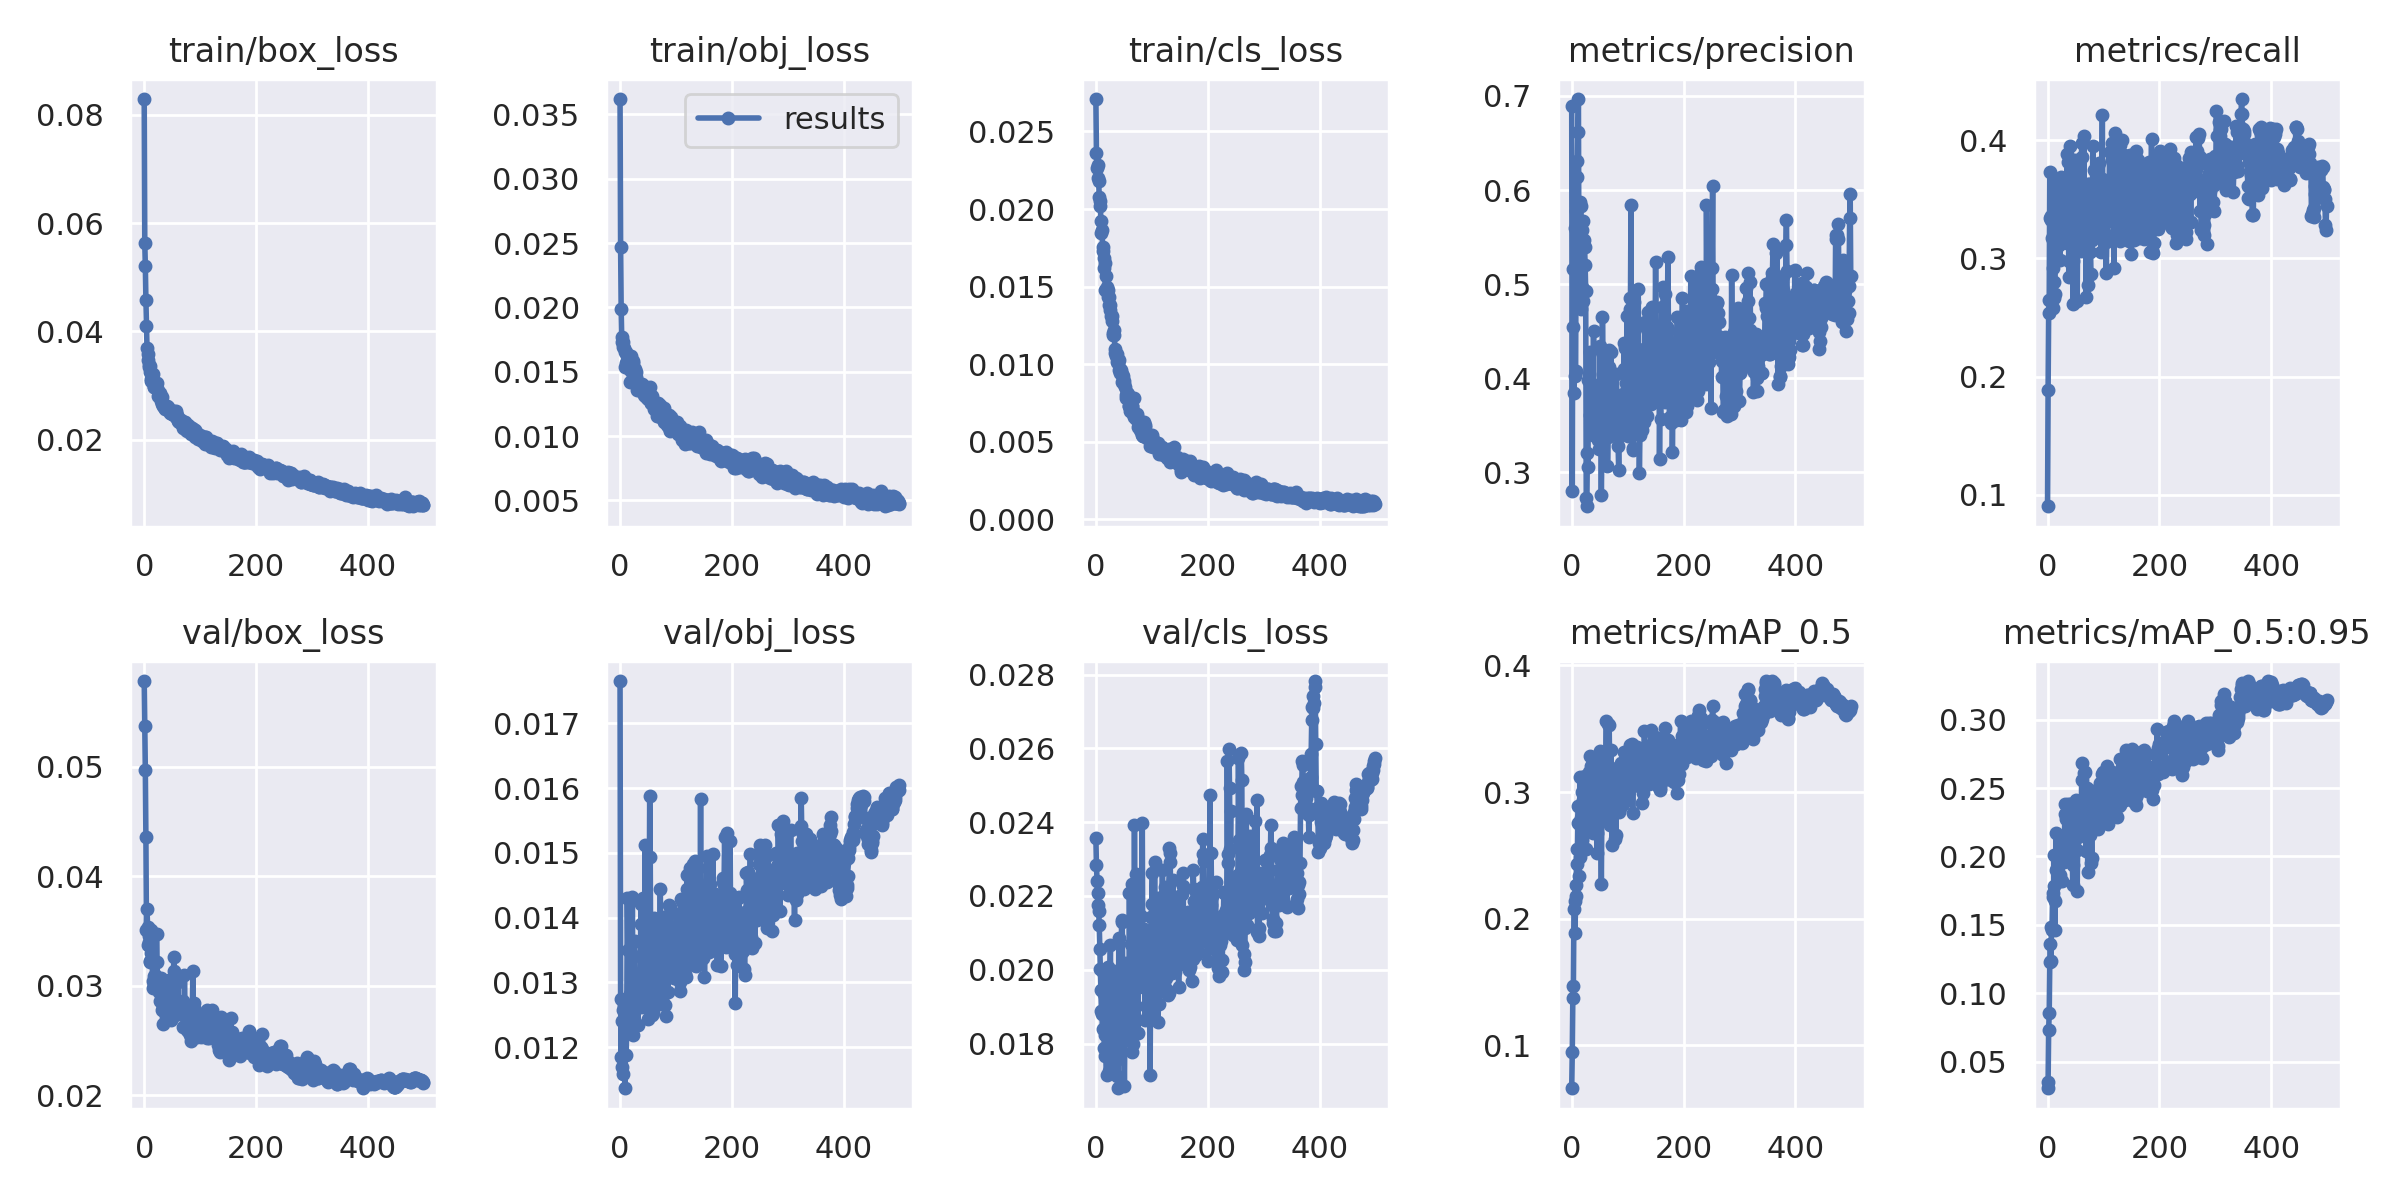

In [ ]:
from IPython import display
display.Image("/content/yolov5/runs/train/exp/results.png")

In [ ]:
%rm -rf /gdrive/MyDrive/yolo_m_500/
%mkdir /gdrive/MyDrive/yolo_m_500/
%cp -r /content/yolov5/runs/train/* /gdrive/MyDrive/yolo_m_500/


In [ ]:

# from google.colab import runtime
# runtime.unassign()